In [1]:
import numpy as np
import torch 
from model import PINNs
import pandas as pd
from utils import charge_data
import json
import matplotlib.pyplot as plt
from plot_results import  plot_loss_decompose, plot_points, plot_loss
from model import PINNs
from utils import charge_data
import json
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import numpy as np
import time as time
import pandas as pd
from geometry import RectangleWithoutCylinder


In [2]:
def true_cl(num, case, time_init, time_max):
    """
    Args:
        num (int): Le numéro du modèle
        case (int): Le numéro du case
        time_init (float): le temps initial 
        time_max (float): le temps max


    Returns:
        time (np.array):  les valeurs de temps
        cl (np.array): la valeur de cl à ces temps
    """
    df = pd.read_csv(f'results_Cl/model_{num}_case_{case}/Cl.csv', index_col=False)
    df_modified = df[((df.iloc[:, 2] > time_init) & (df.iloc[:, 2] < time_max))]
    time = df_modified.iloc[:, 2].to_numpy()
    cl = df_modified.iloc[:, 1].to_numpy()
    return time, cl


In [7]:
hyper_param = {
    "H": [
        261.39,
    ],
    "ya0": [
        0.009375,
    ],
    "m": 1.57,
    "file": [
        "data_john_16_case_1.csv",
    ],
    "nb_epoch": 1000,
    "save_rate": 2,
    "dynamic_weights": False,
    "lr_weights": 0.1,
    "weight_data": 0.5,
    "weight_pde": 0.33,
    "weight_border": 0.5,
    "batch_size": 10000,
    "nb_points_pde": 1000000,
    "Re": 100,
    "lr_init": 0.0005,
    "gamma_scheduler": 0.999,
    "nb_layers": 10,
    "nb_neurons": 64,
    "n_pde_test": 5000,
    "n_data_test": 5000,
    "nb_points": 130,
    "x_min": -0.02,
    "x_max": 0.02,
    "y_min": -0.02,
    "y_max": 0.02,
    "t_min": 6.5,
    "nb_period": 15,
    "nb_period_plot": 2,
    "nb_points_close_cylinder": 200,
    "rayon_close_cylinder": 0.0135,
    "nb_points_border": 200,
    "force_inertie_bool": True
}


param_adim = {"V": 1.0, "L": 0.025, "rho": 1.2}


In [8]:
(
    X_train,
    U_train,
    X_full,
    U_full,
    X_border,
    X_border_test,
    mean_std,
    X_test_data,
    U_test_data,
) = charge_data(hyper_param, param_adim)

fichier n°0 chargé
Starting X_train
Simu n°0/1
Time:3.185
X_train OK
X_border OK


In [9]:
def find_cl_data_piche(num, case, time_init, time_max):
    df = pd.read_csv('data/'+ f"data_john_{num}_case_{case}.csv")
    df_modified = df.loc[
            (df["Time"] > time_init)
            & (df["Time"] < time_init + 3 * (time_max- time_init))
            & (df["Points:2"] == 0.0)
            & (df["Points:0"] ** 2 + df["Points:1"] ** 2 < 1.1* (0.025 / 2) ** 2),
            :,
        ].copy()
    X_theta = np.empty((df_modified.shape[0], 3))
    X_theta[:, 0] = time_init + ((df_modified['Time'].to_numpy() - time_init) % (time_max- time_init) )    #X_full[masque_theta][:, 2] 
    X_theta[:, 2] = df_modified['Pressure'].to_numpy()    #U_full[masque_theta][:, 2]
    X_theta[:, 1] = np.arctan2(df_modified['Points:1'].to_numpy(), df_modified['Points:0'].to_numpy())    #np.atan2(X_full[masque_theta][:, 1] * mean_std['y_std'] + mean_std['y_mean'], X_full[masque_theta][:, 0] * mean_std['x_std'] + mean_std['x_mean'])
    Cl = np.empty(np.unique(X_theta[:, 0]).shape[0])
    for nb, time_ in enumerate(np.unique(X_theta[:, 0])):
        masque_time = X_theta[:, 0] == time_
        indices = np.argsort(X_theta[masque_time][:, 1])[::-1]
        d_theta = X_theta[masque_time][indices][:-1, 1] - X_theta[masque_time][indices][1:, 1]
        Cl[nb] = -np.sum(X_theta[masque_time][indices][1:, 2] * np.sin(X_theta[masque_time][indices][1:, 1])*d_theta*(0.025/2))
    time_predict = np.unique(X_theta[:, 0])    # (X_full[masque_theta][:, 2].unique()* mean_std['t_std'] + mean_std['t_mean']) * (param_adim['L']/ param_adim['V'])
    return time_predict, Cl
    

In [27]:
def find_cl_data(X_full, U_full):
    masque_theta = (X_full[:, 0] * mean_std['x_std'] + mean_std['x_mean'])**2 + (X_full[:, 1] * mean_std['y_std'] + mean_std['y_mean'])**2 < ((0.025/2)/param_adim['L'])**2 * 1.1
    X_theta = torch.empty((X_full[masque_theta].shape[0], 3))
    X_theta[:, 0] = X_full[masque_theta][:, 2] 
    X_theta[:, 2] = (U_full[masque_theta][:, 2]  * mean_std['p_std'] + mean_std['p_mean'])* ((param_adim["V"] ** 2) * param_adim["rho"])
    X_theta[:, 1] = torch.atan2(X_full[masque_theta][:, 1] * mean_std['y_std'] + mean_std['y_mean'], X_full[masque_theta][:, 0] * mean_std['x_std'] + mean_std['x_mean'])
    Cl = torch.empty(X_theta[:, 0].unique().shape[0])
    for nb, time_ in enumerate(X_full[masque_theta][:, 2].unique()):
        masque_time = X_theta[:, 0] == time_
        indices = torch.argsort(X_theta[masque_time][:, 1], descending = True)
        d_theta = X_theta[masque_time][indices][:-1, 1] - X_theta[masque_time][indices][1:, 1]
        Cl[nb] = -torch.sum(X_theta[masque_time][indices][1:, 2] * torch.sin(X_theta[masque_time][indices][1:, 1])*d_theta) * (0.025/2)
    time_predict = (X_full[masque_theta][:, 2].unique()* mean_std['t_std'] + mean_std['t_mean']) * (param_adim['L']/ param_adim['V'])
    return time_predict, Cl
    
    
        

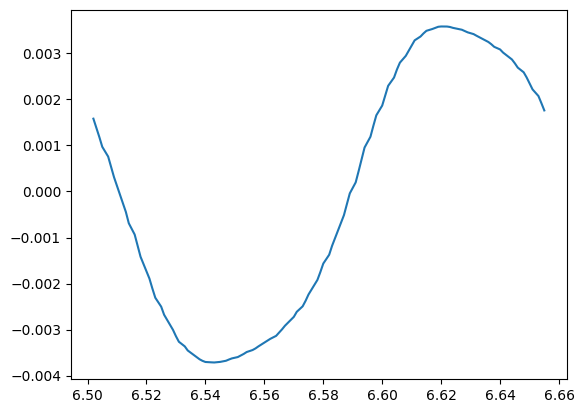

In [29]:
time_predict, Cl_predict = find_cl_data(X_full, U_full)
# time_predict_piche, Cl_predict_piche = find_cl_data_piche(num=16, case=1, time_init = time_predict.min().item(), time_max = time_predict.max().item())
with torch.no_grad():
    plt.plot(time_predict, Cl_predict)
    #plt.plot(time_predict_piche, Cl_predict_piche)

In [38]:
def find_cl_data(num, case, time_init, time_max, param_adim, T,  r=0.025/2):
    df = pd.read_csv('data/'+ f"data_john_{num}_case_{case}.csv")
    df_modified = df.loc[
            (df["Time"] > time_init)
            & (df["Time"] < time_init + 15 * T)
            & (df["Points:2"] == 0.0)
            & (df["Points:0"] ** 2 + df["Points:1"] ** 2 < 1.1* (0.025 / 2) ** 2),
            :,
        ].copy()
    X_theta = np.empty((df_modified.shape[0], 3))
    X_theta[:, 0] = time_init + ((df_modified['Time'].to_numpy() - time_init) % T )    #X_full[masque_theta][:, 2] 
    X_theta[:, 2] = df_modified['Pressure'].to_numpy()    #U_full[masque_theta][:, 2]
    X_theta[:, 1] = np.atan2(df_modified['Points:1'].to_numpy(), df_modified['Points:0'].to_numpy())    #np.atan2(X_full[masque_theta][:, 1] * mean_std['y_std'] + mean_std['y_mean'], X_full[masque_theta][:, 0] * mean_std['x_std'] + mean_std['x_mean'])
    portance = np.empty(np.unique(X_theta[:, 0]).shape[0])
    for nb, time_ in enumerate(np.unique(X_theta[:, 0])):
        masque_time = X_theta[:, 0] == time_
        indices = np.argsort(X_theta[masque_time][:, 1])[::-1]
        d_theta = X_theta[masque_time][indices][:-1, 1] - X_theta[masque_time][indices][1:, 1]
        portance[nb] = -np.sum(X_theta[masque_time][indices][1:, 2] * np.sin(X_theta[masque_time][indices][1:, 1])*d_theta * r)
    time_predict = np.unique(X_theta[:, 0])    # (X_full[masque_theta][:, 2].unique()* mean_std['t_std'] + mean_std['t_mean']) * (param_adim['L']/ param_adim['V'])
    return time_predict, portance / (0.5 * param_adim['rho'] * param_adim['V']**2 * 2 * r)

def find_cl_data_piche(num, case, time_init, time_max, param_adim, T, r=0.025/2):
    df = pd.read_csv('data/'+ f"data_john_{num}_case_{case}.csv")
    df_modified = df.loc[
            (df["Time"] > time_init)
            & (df["Time"] < time_init + 15 * T)
            & (df["Points:2"] == 0.0)
            & (df["Points:0"] ** 2 + df["Points:1"] ** 2 < 1.1* (0.025 / 2) ** 2),
            :,
        ].copy()
    X_theta = np.empty((df_modified.shape[0], 3))
    X_theta[:, 0] = time_init + ((df_modified['Time'].to_numpy() - time_init) % T )    #X_full[masque_theta][:, 2] 
    X_theta[:, 2] = df_modified['Pressure'].to_numpy()    #U_full[masque_theta][:, 2]
    X_theta[:, 1] = np.atan2(df_modified['Points:1'].to_numpy(), df_modified['Points:0'].to_numpy())    #np.atan2(X_full[masque_theta][:, 1] * mean_std['y_std'] + mean_std['y_mean'], X_full[masque_theta][:, 0] * mean_std['x_std'] + mean_std['x_mean'])
    portance = np.empty(np.unique(X_theta[:, 0]).shape[0])
    for nb, time_ in enumerate(np.unique(X_theta[:, 0])):
        masque_time = X_theta[:, 0] == time_
        indices = np.argsort(X_theta[masque_time][:, 1])
        d_theta = X_theta[masque_time][indices][1:, 1] - X_theta[masque_time][indices][:-1, 1]
        portance[nb] = -np.sum(X_theta[masque_time][indices][1:, 2] * np.sin(X_theta[masque_time][indices][1:, 1])*d_theta * r)
    time_predict = np.unique(X_theta[:, 0])    # (X_full[masque_theta][:, 2].unique()* mean_std['t_std'] + mean_std['t_mean']) * (param_adim['L']/ param_adim['V'])
    return time_predict, portance / (0.5 * param_adim['rho'] * param_adim['V']**2 * 2 * r)

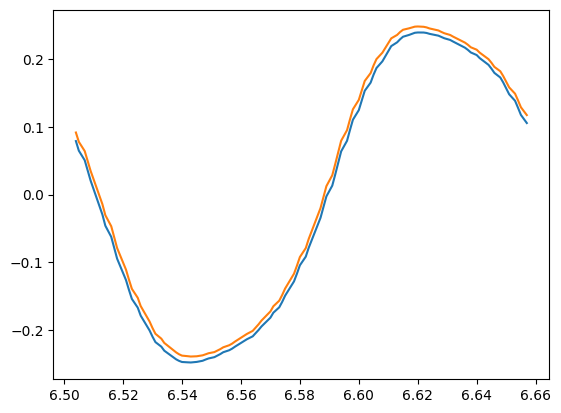

In [39]:
T = 1/(0.5 * (hyper_param["H"][0] / hyper_param["m"]) ** 0.5)
time_predict2, Cl_predict = find_cl_data(num=16, case=1, time_init = time_predict.min().item(), time_max = time_predict.max().item(), T=T, param_adim=param_adim)
time_predict_piche, Cl_predict_piche = find_cl_data_piche(num=16, case=1, time_init = time_predict.min().item(), time_max = time_predict.max().item(), T=T, param_adim=param_adim)
with torch.no_grad():
    plt.plot(time_predict2, Cl_predict)
    plt.plot(time_predict_piche, Cl_predict_piche)

In [32]:
masque_theta = (X_full[:, 0] * mean_std['x_std'] + mean_std['x_mean'])**2 + (X_full[:, 1] * mean_std['y_std'] + mean_std['y_mean'])**2 < ((0.025/2)/param_adim['L'])**2 * 1.1

In [33]:
masque_theta.sum()

tensor(9500)

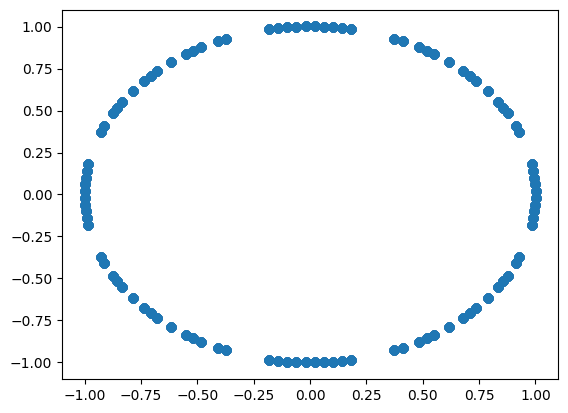

In [9]:
with torch.no_grad():   
    plt.scatter(X_full[masque_theta][:, 0], X_full[masque_theta][:,1] )

In [27]:
X_theta = torch.empty((X_full[masque_theta].shape[0], 3))

In [28]:
X_theta[:, 0] = X_full[masque_theta][:, 2] 
X_theta[:, 2] = U_full[masque_theta][:, 2]
X_theta[:, 1] = torch.atan2(X_full[masque_theta][:, 1] * mean_std['y_std'] + mean_std['y_mean'], X_full[masque_theta][:, 0] * mean_std['x_std'] + mean_std['x_mean'])

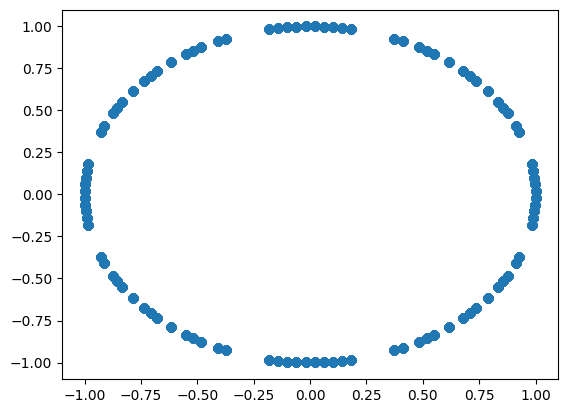

In [29]:
with torch.no_grad():
    plt.scatter(torch.cos(X_theta[:, 1]), torch.sin(X_theta[:, 1]))

In [30]:
dtheta = X_theta[1:, 1] - X_theta[:-1, 1]

In [31]:
dtheta

tensor([-1.5708, -1.5708, -1.5708,  ..., -0.0403, -0.0806, -0.0806])

In [32]:
Cl = torch.empty(X_theta[:, 0].unique().shape[0])

In [33]:
Cl

tensor([ 1.3275e-01,  4.5793e-41, -6.4508e-18,  3.0680e-41, -1.0592e-16,
         3.0680e-41, -8.2291e-17,  3.0680e-41,  0.0000e+00,  0.0000e+00,
        -2.0393e-17,  3.0680e-41, -1.9047e-19,  3.0680e-41, -2.1988e+33,
         4.5789e-41,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.4013e-45,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  9.7530e-43,  0.0000e+00,
         1.4013e-45,  0.0000e+00, -1.7014e+38,  1.1515e-40,  4.5919e-41,
         4.1478e-43,  4.4982e-43,  0.0000e+00, -5.8906e-18,  3.0680e-41,
        -8.2290e-17,  3.0680e-41,  4.4842e-44,  0.0000e+00,  2.6905e-43,
         0.0000e+00,  2.9367e+28,  4.5792e-41,  0.0000e+00,  1.4013e-45,
        -1.0592e-16,  3.0680e-41, -8.2293e-17,  3.0680e-41,  0.0000e+00,
         0.0000e+00, -2.0393e-17,  3.0680e-41, -1.9

In [34]:
for nb, time_ in enumerate(X_full[masque_theta][:, 2].unique()):
    masque_time = X_theta[:, 0] == time_
    indices = torch.argsort(X_theta[masque_time][:, 1], descending = True)
    d_theta = X_theta[masque_time][indices][:-1, 1] - X_theta[masque_time][indices][1:, 1]
    Cl[nb] = -torch.sum(X_theta[masque_time][indices][1:, 2] * torch.sin(X_theta[masque_time][indices][1:, 1])*d_theta) * 0.025/2

In [35]:
Cl

tensor([ 3.4439e-03,  2.5761e-03,  2.1142e-03,  1.6537e-03,  1.1673e-03,
         6.7911e-04, -9.6088e-04, -1.4954e-03, -2.0293e-03, -2.5529e-03,
        -3.0781e-03, -4.1095e-03, -4.5772e-03, -5.0147e-03, -5.4358e-03,
        -5.8195e-03, -6.5332e-03, -6.8318e-03, -7.0933e-03, -7.3118e-03,
        -7.5048e-03, -7.9198e-03, -7.9947e-03, -8.0488e-03, -8.0656e-03,
        -8.0724e-03, -8.0448e-03, -7.9905e-03, -7.9318e-03, -7.8796e-03,
        -7.8164e-03, -7.6678e-03, -7.5789e-03, -7.4850e-03, -7.4085e-03,
        -7.3116e-03, -6.9568e-03, -6.8149e-03, -6.6608e-03, -6.5087e-03,
        -6.3380e-03, -5.9171e-03, -5.6787e-03, -5.4204e-03, -5.1596e-03,
        -4.8598e-03, -4.1725e-03, -3.8012e-03, -3.3999e-03, -2.9839e-03,
        -2.5578e-03, -1.1139e-03, -5.9692e-04, -8.3885e-05,  4.3446e-04,
         9.6461e-04,  2.0813e-03,  2.5908e-03,  3.1097e-03,  3.6031e-03,
         4.0633e-03,  4.9951e-03,  5.3864e-03,  5.7685e-03,  6.0903e-03,
         6.4106e-03,  7.1446e-03,  7.3261e-03,  7.4

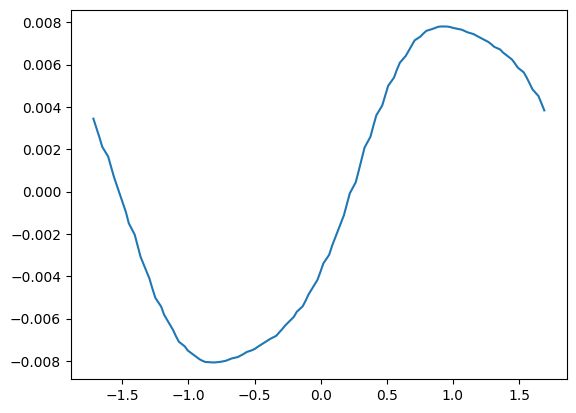

In [36]:
with torch.no_grad():
    plt.plot(X_full[masque_theta][:, 2].unique(), Cl)
    time, cl_true = true_cl(num=16, case=1, time_init=hyper_param['t_min'], time_max=X_full[:, 2].max().item())
    plt.plot(time, cl_true)


In [37]:
time_predict = (X_full[masque_theta][:, 2].unique()* mean_std['t_std'] + mean_std['t_mean']) * (param_adim['L']/ param_adim['V'])

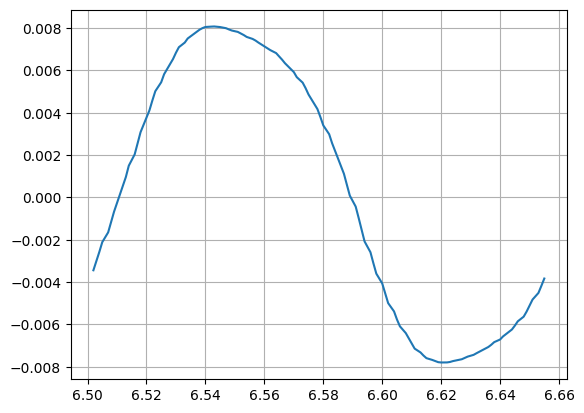

In [38]:
with torch.no_grad():
    plt.plot(time_predict, -Cl)
    plt.plot(time, cl_true)
    plt.grid()


In [89]:
time_max = (X_full[:, 2].max().item() * mean_std['t_std'] + mean_std['t_mean']) * (param_adim['L']/ param_adim['V'])

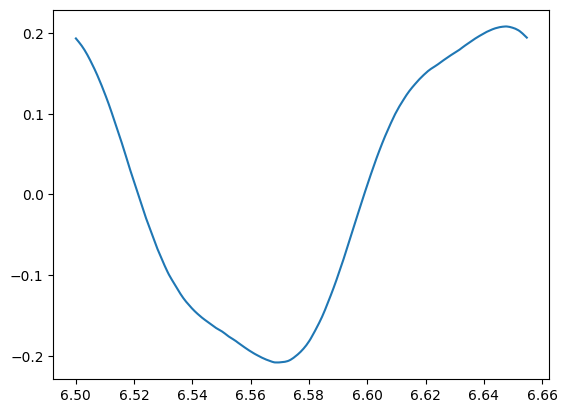

In [92]:
time, cl_true = true_cl(num=16, case=1, time_init=hyper_param['t_min'], time_max=time_max.item())
plt.plot(time, cl_true)

array([], dtype=float64)

In [73]:
Cl[0] = X_theta[indices][1:, 2] * torch.sin(X_theta[indices][1:, 1])*d_theta

RuntimeError: expand(torch.FloatTensor{[99]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)

In [61]:
X_theta[indices][1:, 2]

tensor([ 2.0705,  2.0627,  2.0424,  2.0098,  1.6718,  1.5724,  1.3458,  1.2199,
         1.0872,  0.8075,  0.5133,  0.3640,  0.2150, -0.0786, -0.3570, -0.4879,
        -0.6134, -0.8407, -0.9399, -1.2715, -1.3035, -1.3240, -1.3329, -1.3311,
        -1.3192, -1.2976, -1.2676, -1.2300, -1.1861, -0.9053, -0.8455, -0.7295,
        -0.6756, -0.6251, -0.5355, -0.4622, -0.4318, -0.4055, -0.3661, -0.3448,
        -0.3404, -0.3398, -0.3489, -0.3572, -0.4094, -0.4179, -0.4248, -0.4298,
        -0.4333, -0.4351, -0.4355, -0.4348, -0.4335, -0.4327, -0.4535, -0.4657,
        -0.4986, -0.5184, -0.5397, -0.5838, -0.6256, -0.6445, -0.6615, -0.6897,
        -0.7111, -0.7195, -0.7274, -0.7411, -0.7476, -0.7807, -0.7867, -0.7917,
        -0.7957, -0.7981, -0.7983, -0.7957, -0.7900, -0.7804, -0.7665, -0.6099,
        -0.5584, -0.4322, -0.3578, -0.2763, -0.0912,  0.1189,  0.2305,  0.3466,
         0.5879,  0.8345,  0.9576,  1.0789,  1.3114,  1.4213,  1.8656,  1.9276,
         1.9789,  2.0194,  2.0487])

In [52]:
indices = torch.argsort(X_theta[masque_time][:, 1], descending = True)

In [58]:
X_theta[masque_time][indices][:-1, 1] - X_theta[masque_time][indices][1:, 1]

tensor([0.0403, 0.0403, 0.0402, 0.0403, 0.2013, 0.0403, 0.0806, 0.0402, 0.0403,
        0.0806, 0.0806, 0.0403, 0.0403, 0.0806, 0.0806, 0.0403, 0.0402, 0.0806,
        0.0403, 0.2013, 0.0403, 0.0402, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403,
        0.0402, 0.0403, 0.2013, 0.0403, 0.0806, 0.0402, 0.0403, 0.0806, 0.0806,
        0.0403, 0.0403, 0.0806, 0.0806, 0.0403, 0.0402, 0.0806, 0.0403, 0.2013,
        0.0403, 0.0402, 0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0402, 0.0403,
        0.2013, 0.0403, 0.0806, 0.0402, 0.0403, 0.0806, 0.0806, 0.0403, 0.0403,
        0.0806, 0.0806, 0.0403, 0.0402, 0.0806, 0.0403, 0.2013, 0.0403, 0.0402,
        0.0403, 0.0403, 0.0403, 0.0403, 0.0403, 0.0402, 0.0403, 0.2013, 0.0403,
        0.0806, 0.0402, 0.0403, 0.0806, 0.0806, 0.0403, 0.0403, 0.0806, 0.0806,
        0.0403, 0.0402, 0.0806, 0.0403, 0.2013, 0.0403, 0.0402, 0.0403, 0.0403])

In [53]:
indices

tensor([88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99,  0,  4,  5,  6,  7,  8,
         9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
        27,  1, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 47, 48, 49, 50, 51,  2, 52, 53, 54, 55, 56, 57, 58, 59, 60,
        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,  3, 76, 77,
        78, 79, 80, 81, 82, 83, 84, 85, 86, 87])

In [51]:
"""
Charge the data of X_full, U_full with every points
And X_train, U_train with less points
"""
# La data
# On adimensionne la data

time_start_charge = time.time()
nb_simu = len(hyper_param["file"])
x_full, y_full, t_full, ya0_full, w0_full = [], [], [], [], []
u_full, v_full, p_full = [], [], []
x_norm_full, y_norm_full, t_norm_full, ya0_norm_full, w0_norm_full = (
    [],
    [],
    [],
    [],
    [],
)
u_norm_full, v_norm_full, p_norm_full = [], [], []
H_numpy = np.array(hyper_param["H"])
f_numpy = 0.5 * (H_numpy / hyper_param["m"]) ** 0.5
f = np.min(f_numpy)
time_tot = hyper_param["nb_period_plot"] / f  # la fréquence de l'écoulement
t_max = hyper_param["t_min"] + hyper_param["nb_period"] * time_tot
t_max_plot = hyper_param["t_min"] + time_tot
t_max = hyper_param["t_min"] + hyper_param["nb_period"] / f
for k in range(nb_simu):
    df = pd.read_csv("data/" + hyper_param["file"][k])
    # df_modified = df.loc[
    #     (df["Points:0"] >= hyper_param["x_min"])
    #     & (df["Points:0"] <= hyper_param["x_max"])
    #     & (df["Points:1"] >= hyper_param["y_min"])
    #     & (df["Points:1"] <= hyper_param["y_max"])
    #     & (df["Time"] > hyper_param["t_min"])
    #     & (df["Time"] < t_max)
    #     & (df["Points:2"] == 0.0)
    #     & (df["Points:0"] ** 2 + df["Points:1"] ** 2 > (0.025 / 2) ** 2),
    #     :,
    # ].copy()
    df_modified = df.loc[
        (df["Time"] > hyper_param["t_min"])
        & (df["Time"] < t_max)
        & (df["Points:2"] == 0.0)
        & (df["Points:0"] ** 2 + df["Points:1"] ** 2 < 1.1* (0.025 / 2) ** 2),
        :,
    ].copy()
    df_modified.loc[:, "ya0"] = hyper_param["ya0"][k]
    df_modified.loc[:, "w0"] = (
        torch.pi * (hyper_param["H"][k] / hyper_param["m"]) ** 0.5
    )

    # Adimensionnement
    x_full.append(
        torch.tensor(df_modified["Points:0"].to_numpy(), dtype=torch.float32)
        / param_adim["L"]
    )
    y_full.append(
        torch.tensor(df_modified["Points:1"].to_numpy(), dtype=torch.float32)
        / param_adim["L"]
    )
    f_flow = f_numpy[k]
    time_without_modulo = df_modified["Time"].to_numpy() - hyper_param["t_min"]
    time_with_modulo = hyper_param["t_min"] + time_without_modulo % (1 / f_flow)
    t_full.append(
        torch.tensor(time_with_modulo, dtype=torch.float32)
        / (param_adim["L"] / param_adim["V"])
    )
    ya0_full.append(
        torch.tensor(df_modified["ya0"].to_numpy(), dtype=torch.float32)
        / param_adim["L"]
    )
    w0_full.append(
        torch.tensor(df_modified["w0"].to_numpy(), dtype=torch.float32)
        / (param_adim["V"] / param_adim["L"])
    )
    u_full.append(
        torch.tensor(df_modified["Velocity:0"].to_numpy(), dtype=torch.float32)
        / param_adim["V"]
    )
    v_full.append(
        torch.tensor(df_modified["Velocity:1"].to_numpy(), dtype=torch.float32)
        / param_adim["V"]
    )
    p_full.append(
        torch.tensor(df_modified["Pressure"].to_numpy(), dtype=torch.float32)
        / ((param_adim["V"] ** 2) * param_adim["rho"])
    )
    print(f"fichier n°{k} chargé")

# les valeurs pour renormaliser ou dénormaliser
if nb_simu == 1:
    w0_std = torch.ones(1)
    ya0_std = torch.ones(1)
else: 
    w0_std = torch.cat([w0 for w0 in w0_full], dim=0).std()
    ya0_std = torch.cat([ya0 for ya0 in ya0_full], dim=0).std()
mean_std = {
    "u_mean": torch.cat([u for u in u_full], dim=0).mean(),
    "v_mean": torch.cat([v for v in v_full], dim=0).mean(),
    "p_mean": torch.cat([p for p in p_full], dim=0).mean(),
    "x_mean": torch.cat([x for x in x_full], dim=0).mean(),
    "y_mean": torch.cat([y for y in y_full], dim=0).mean(),
    "t_mean": torch.cat([t for t in t_full], dim=0).mean(),
    "x_std": torch.cat([x for x in x_full], dim=0).std(),
    "y_std": torch.cat([y for y in y_full], dim=0).std(),
    "t_std": torch.cat([t for t in t_full], dim=0).std(),
    "u_std": torch.cat([u for u in u_full], dim=0).std(),
    "v_std": torch.cat([v for v in v_full], dim=0).std(),
    "p_std": torch.cat([p for p in p_full], dim=0).std(),
    "ya0_mean": torch.cat([ya0 for ya0 in ya0_full], dim=0).mean(),
    "ya0_std": ya0_std,
    "w0_mean": torch.cat([w0 for w0 in w0_full], dim=0).mean(),
    "w0_std": w0_std,
}

X_full = torch.zeros((0, 5))
U_full = torch.zeros((0, 3))
for k in range(nb_simu):
    # Normalisation Z
    x_norm_full.append((x_full[k] - mean_std["x_mean"]) / mean_std["x_std"])
    y_norm_full.append((y_full[k] - mean_std["y_mean"]) / mean_std["y_std"])
    t_norm_full.append((t_full[k] - mean_std["t_mean"]) / mean_std["t_std"])
    ya0_norm_full.append((ya0_full[k] - mean_std["ya0_mean"]) / mean_std["ya0_std"])
    w0_norm_full.append((w0_full[k] - mean_std["w0_mean"]) / mean_std["w0_std"])
    p_norm_full.append((p_full[k] - mean_std["p_mean"]) / mean_std["p_std"])
    u_norm_full.append((u_full[k] - mean_std["u_mean"]) / mean_std["u_std"])
    v_norm_full.append((v_full[k] - mean_std["v_mean"]) / mean_std["v_std"])
    X_full = torch.cat(
        (
            X_full,
            torch.stack(
                (
                    x_norm_full[-1],
                    y_norm_full[-1],
                    t_norm_full[-1],
                    ya0_norm_full[-1],
                    w0_norm_full[-1],
                ),
                dim=1,
            ),
        )
    )
    U_full = torch.cat(
        (
            U_full,
            torch.stack((u_norm_full[-1], v_norm_full[-1], p_norm_full[-1]), dim=1),
        )
    )

X_train = torch.zeros((0, 5))
U_train = torch.zeros((0, 3))
print("Starting X_train")
for nb, ya0_ in enumerate(hyper_param["ya0"]):
    print(f"Simu n°{nb}/{len(hyper_param['ya0'])}")
    print(f"Time:{(time.time()-time_start_charge):.3f}")
    w_0 = w0_norm_full[nb][0].item()
    for time_ in torch.unique(t_norm_full[nb]):
        # les points autour du cylindre dans un rayon de hyper_param['rayon_proche']
        masque = (
            (x_full[nb] ** 2 + y_full[nb] ** 2)
            < ((hyper_param["rayon_close_cylinder"] / param_adim["L"]) ** 2)
        ) & (t_norm_full[nb] == time_)
        indices = torch.randperm(len(x_norm_full[nb][masque]))[
            : hyper_param["nb_points_close_cylinder"]
        ]

        
        new_x = torch.stack(
            (
                x_norm_full[nb][masque][indices],
                y_norm_full[nb][masque][indices],
                t_norm_full[nb][masque][indices],
                ya0_norm_full[nb][masque][indices],
                torch.ones(indices.shape[0]) * w_0,
            ),
            dim=1,
        )
        new_y = torch.stack(
            (
                u_norm_full[nb][masque][indices],
                v_norm_full[nb][masque][indices],
                p_norm_full[nb][masque][indices],
            ),
            dim=1,
        )
        X_train = torch.cat((X_train, new_x))
        U_train = torch.cat((U_train, new_y))

        # Les points avec 'latin hypercube sampling'
        masque = t_norm_full[nb] == time_
        if x_norm_full[nb][masque].size(0) > 0:
            indices = torch.randperm(x_norm_full[nb][masque].size(0))[
                : hyper_param["nb_points"]
            ]
            new_x = torch.stack(
                (
                    x_norm_full[nb][masque][indices],
                    y_norm_full[nb][masque][indices],
                    t_norm_full[nb][masque][indices],
                    ya0_norm_full[nb][masque][indices],
                    torch.ones(indices.shape[0]) * w_0,
                ),
                dim=1,
            )
            new_y = torch.stack(
                (
                    u_norm_full[nb][masque][indices],
                    v_norm_full[nb][masque][indices],
                    p_norm_full[nb][masque][indices],
                ),
                dim=1,
            )
            X_train = torch.cat((X_train, new_x))
            U_train = torch.cat((U_train, new_y))
indices = torch.randperm(X_train.size(0))
X_train = X_train[indices]
U_train = U_train[indices]
print("X_train OK")

# les points du bord
teta_int = torch.linspace(0, 2 * torch.pi, hyper_param["nb_points_border"])
X_border = torch.empty((0, 5))
x_ = (
    (((0.025 / 2) * torch.cos(teta_int)) / param_adim["L"]) - mean_std["x_mean"]
) / mean_std["x_std"]
y_ = (
    (((0.025 / 2) * torch.sin(teta_int)) / param_adim["L"]) - mean_std["y_mean"]
) / mean_std["y_std"]

for nb, ya0_ in enumerate(X_train[:, 3].unique()):
    for time_ in torch.unique(t_norm_full[nb]):
        new_x = torch.stack(
            (
                x_,
                y_,
                torch.ones_like(x_) * time_,
                torch.ones_like(x_) * ya0_,
                torch.ones_like(x_) * w0_norm_full[nb][0],
            ),
            dim=1,
        )
        X_border = torch.cat((X_border, new_x))
    indices = torch.randperm(X_border.size(0))
    X_border = X_border[indices]
print("X_border OK")

teta_int_test = torch.linspace(0, 2 * torch.pi, 15)
X_border_test = torch.zeros((0, 5))
x_ = (
    (((0.025 / 2) * torch.cos(teta_int_test)) / param_adim["L"])
    - mean_std["x_mean"]
) / mean_std["x_std"]
y_ = (
    (((0.025 / 2) * torch.sin(teta_int_test)) / param_adim["L"])
    - mean_std["y_mean"]
) / mean_std["y_std"]

for nb, ya0_ in enumerate(X_train[:, 3].unique()):
    for time_ in torch.unique(t_norm_full[nb]):
        new_x = torch.stack(
            (
                x_,
                y_,
                torch.ones_like(x_) * time_,
                torch.ones_like(x_) * ya0_,
                torch.ones_like(x_) * w0_norm_full[nb][0],
            ),
            dim=1,
        )
        X_border_test = torch.cat((X_border_test, new_x))

points_coloc_test = np.random.choice(
    len(X_full), hyper_param["n_data_test"], replace=False
)
X_test_data = X_full[points_coloc_test]
U_test_data = U_full[points_coloc_test]


fichier n°0 chargé
Starting X_train
Simu n°0/1
Time:2.212
X_train OK
X_border OK


In [54]:
X_train

tensor([[-5.2789e-01, -1.3121e+00,  1.3564e+00,  0.0000e+00, -1.1921e-07],
        [-1.9862e-01, -1.4003e+00,  1.4902e+00,  0.0000e+00, -1.1921e-07],
        [-8.5365e-02,  1.4116e+00,  8.8891e-01,  0.0000e+00, -1.1921e-07],
        ...,
        [-1.1130e+00,  8.7197e-01,  4.2084e-01,  0.0000e+00, -1.1921e-07],
        [ 1.1797e+00, -7.7956e-01, -1.0716e+00,  0.0000e+00, -1.1921e-07],
        [-9.5873e-01,  1.0393e+00, -1.0716e+00,  0.0000e+00, -1.1921e-07]])

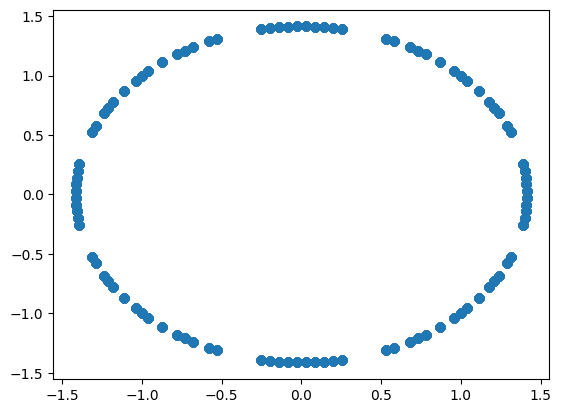

In [57]:
with torch.no_grad():
    plt.scatter(X_full[:, 0], X_full[:, 1])

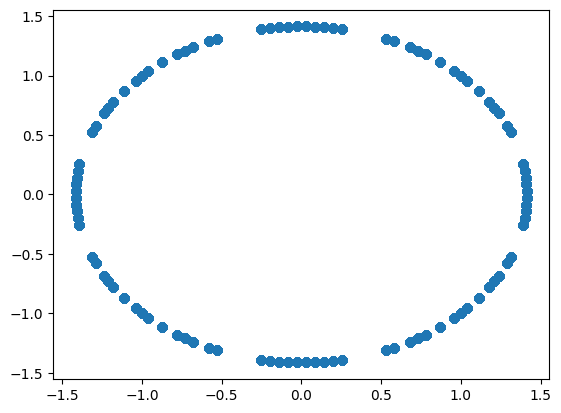

In [58]:
with torch.no_grad():
    plt.scatter(X_train[:, 0], X_train[:, 1])

In [52]:
indices.shape[0]

19000

In [53]:
charge_data(hyper_param, param_adim)

fichier n°0 chargé
Starting X_train
Simu n°0/1
Time:2.142


RuntimeError: stack expects each tensor to be equal size, but got [100] at entry 0 and [4950] at entry 4